RuntimeError: No active exception to reraise

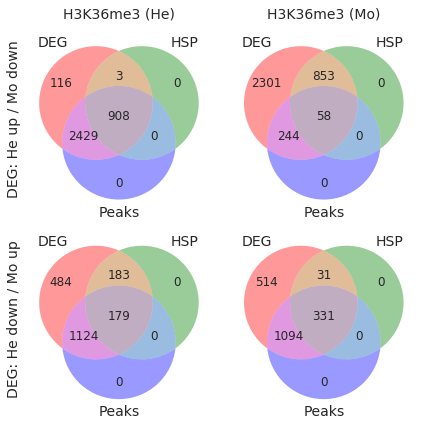

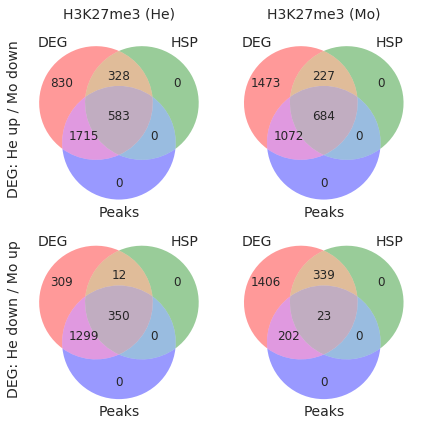

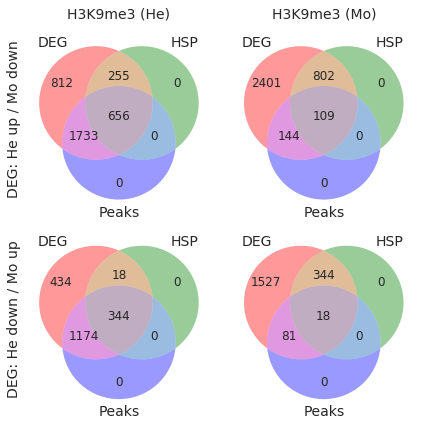

In [32]:
%matplotlib inline

import os as os
import csv as csv
import collections as col
import operator as op
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib_venn as vnn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot HSP overlaps with
# DE genes and PePr peaks
# as Venn diagram

date = '20180627'

run_hsp_deg_pepr_venn = True

save_figures = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'ox_bioinf'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['emission', 'replicate']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep', 'pepr_isect')
diff_genes_root = os.path.join(fhgfs_base, 'deseq', 'bed_out')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')


def read_de_gene_table(fpath):
    """
    Read table of DE genes, gives
    total number and LUT to check
    for enhancer annotation
    """
    de_genes = pd.read_csv(fpath, header=0, sep='\t')
    de_genes = de_genes[['name', 'symbol', 'log2fc']]
    # remove Ensembl ID part after "."
    de_genes['name'] = de_genes['name'].str.extract('(?P<ENS>\w+)', expand=False)
    known_genes = dict((n, (n, s)) for n, s in zip(de_genes['name'], de_genes['symbol']))
    known_symbols = dict((s, (n, s)) for n, s in zip(de_genes['name'], de_genes['symbol']))
    return de_genes, known_genes, known_symbols


def read_overlap_table(fpath, ovl_type):
    """
    """
    ovl_header = {'gene': ['exp_class', 'chrom', 'start', 'end', 'name',
                           'log2fc', 'strand', 'symbol', 'pv_adj'],
                  'prom': ['exp_class', 'chrom', 'start', 'end', 'name',
                           'log2fc', 'strand', 'symbol', 'pv_adj'],
                  'enh': ['chrom', 'start', 'end', 'GHid', 'enhancer_score',
                          'is_elite', 'cluster_id', 'name', 'symbol',
                          'assoc_score', 'enh_gene_dist']}
    hsp_header = open(fpath, 'r').readline().strip().split('\t')
    hsp_header[0] = 'chrom'
    hsp_header = ['hsp_' + h for h in hsp_header]
    file_header = hsp_header + ovl_header[ovl_type] + ['overlap']
    
    if ovl_type == 'enh':
        df = []
        with open(fpath, 'r', newline='') as tsv:
            _ = tsv.readline()
            rows = csv.DictReader(tsv, fieldnames=file_header, delimiter='\t')
            for row in rows:
                if int(row['overlap']) > 0:
                    ensembl_ids = row['name'].split(',')
                    symbols = row['symbol'].split(',')
                    dists = row['enh_gene_dist'].split(',')
                    for e, s, d in zip(ensembl_ids, symbols, dists):
                        if e == 'n/a' and s == 'n/a':
                            continue
                        else:
                            df.append((e, s, row['GHid'],
                                       int(row['is_elite']),
                                       float(row['hsp_nat_score_lnorm']),
                                       float(row['enhancer_score']),
                                       int(d)))
        df = pd.DataFrame(df, columns=['name', 'symbol', 'ghid', 'is_elite',
                                       'nat_score_lnorm', 'enh_score', 'eg_dist'])
    else:
        df = pd.read_csv(fpath, sep='\t', skiprows=1, header=None, names=file_header)
        sub_select = np.logical_and(df['exp_class'] == 'DIFF',
                                    df['overlap'].astype(np.int32) > 0)
        df = df.loc[sub_select, :].copy()
        df['name'] = df['name'].str.extract('(?P<ENS>\w+)', expand=False)
        df = df[['name', 'symbol', 'hsp_nat_score_lnorm', 'log2fc']]
        df.columns = ['name', 'symbol', 'nat_score_lnorm', 'log2fc']
        tmp = df.groupby(['name', 'symbol'], as_index=False)['nat_score_lnorm'].mean()
        df.drop_duplicates(['name', 'symbol'], inplace=True)
        df.drop('nat_score_lnorm', inplace=True, axis=1)
        df = df.merge(tmp, on=['name', 'symbol'], how='outer')
    return df


def cache_deg_pepr_overlaps(cache_file, hsp_pepr_ovl):
    """
    """
    cache_data = dict()
    for tsv in os.listdir(hsp_pepr_ovl):
        tsv_overlaps = col.defaultdict(set)
        tsv_path = os.path.join(hsp_pepr_ovl, tsv)
        # degenes_body_hsp_pepr_cmm18_HG_vs_He_emission.tsv
        _, regtype, _ , _, seg, c1, _, c2, score = tsv.split('.')[0].split('_')
        comp = c1 + '_vs_' + c2
        
        with open(tsv_path, 'r') as table:
            _ = table.readline()
            for line in table:
                if line.strip():
                    columns = line.strip().split()
                    ensid = columns[3].split('.')[0]
                    fc = float(columns[4])
                    change = -1 if fc < 0 else 1
                    tsv_overlaps[('genes', change)].add(ensid)
                    ovl = int(columns[-1])
                    if ovl > 0:
                        src = columns[8]
                        tsv_overlaps[(src, change)].add(ensid)
                    else:
                        continue
        cache_data[(seg, score, comp, regtype)] = tsv_overlaps
                       
    with open(cache_file, 'wb') as dump:
        pck.dump(cache_data, dump)
    return cache_file


def make_venn_diagram(overlaps, comp, mark, fkey):
    """
    """        
    ncols = 2
    nrows = 2
    
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=nrows, ncols=ncols, frameon=True,
                             sharex=False, sharey=False)
    c1, c2 = comp.split('_vs_')
    top_left = ('{}-{}'.format(c1, mark), 1), 0, 0
    top_right = ('{}-{}'.format(c2, mark), 1), 0, 1
    bottom_left = ('{}-{}'.format(c1, mark), -1), 1, 0
    bottom_right = ('{}-{}'.format(c2, mark), -1), 1, 1
    
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
    for select, r, c in [top_left, top_right,
                         bottom_left, bottom_right]:
        ax = axes[r][c]
        genes = overlaps[('genes', select[1])]
        hsps = overlaps[('HSP', select[1])]
        peaks = overlaps[select]
        
        vd = vnn.venn3_unweighted([genes, hsps, peaks], ('DEG', 'HSP', 'Peaks'), ax=ax)
        for text in vd.set_labels:
            text.set_fontsize(14)
        for text in vd.subset_labels:
            text.set_fontsize(12)
        if r == 0:
            if c == 0:
                cell = c1
            else:
                cell = c2
            tt = ax.set_title('{} ({})'.format(mark, cell), fontsize=14)
            tt.set_position((0.5, 1.05))
        if c == 0:
            if r == 0:
                label = 'DEG: {} up / {} down'.format(c1, c2)
            else:
                label = 'DEG: {} down / {} up'.format(c1, c2)
            ax.text(-0.1, 0.9, label, fontdict={'fontsize': 14},
                    transform=ax.transAxes, rotation=90)
                
    return fig, []


def plot_hsp_deg_pepr_venn():
    cache_file = os.path.join(cache_dir, '{}_plot_hsp_deg_pepr_venn.pck'.format(date))
    if not os.path.isfile(cache_file) or os.stat(cache_file).st_size < 1e5:
        print('Caching')
        _ = cache_deg_pepr_overlaps(cache_file, isect_root)
    with open(cache_file, 'rb') as dump:
        cache_data = pck.load(dump)
        cached_keys = list(cache_data.keys())
        for k in cached_keys:
            if 'cmm18' not in k and 'emission' not in k:
                continue
            overlaps = cache_data[k]
            fk = 'X'
            for m in ['H3K36me3', 'H3K27me3', 'H3K9me3']:
            
                fig, exart = make_venn_diagram(overlaps, k[2], m, 'Figure ' + fk)

                if save_figures:
                    outname = 'fig_{}_deg-hsp-pepr_venn_{}_{}_{}_{}'.format(fk, k[0], k[1], k[2], m)
                    out_folder = fig_collect
                    
                    out_pdf = os.path.join(out_folder, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)

                    out_png = os.path.join(out_folder, outname + '.png')
                    fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
            raise
    return



if run_hsp_deg_pepr_venn:
    plot_hsp_deg_pepr_venn()
